In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model

In [2]:
# Chemins vers les images et les données CSV
images_path = "../../data/raw/images/image_train"
X_csv_path = "../../data/processed/X_train_update (komla).csv"
y_csv_path = "../../data/processed/Y_train_CVw08PX (komla).csv"

# Chargement des données
X_df = pd.read_csv(X_csv_path)
y_df = pd.read_csv(y_csv_path)

# Nettoyage de y_df pour enlever toute colonne superflue (comme 'Unnamed: 0')
y_df.drop(columns=["Unnamed: 0"], inplace=True)
X_df.drop(columns=["Unnamed: 0"], inplace=True)

# Assurez-vous que les colonnes 'imageid' et 'productid' sont correctes pour correspondre aux noms de fichiers
X_df["image_name"] = X_df.apply(
    lambda row: f"image_{row['imageid']}_product_{row['productid']}.jpg", axis=1
)
X_df["image_path"] = images_path + "/" + X_df["image_name"]

# Concaténation de X_df avec y_df sur l'index
dataset = pd.concat([X_df, y_df], axis=1)

In [3]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    dataset["image_path"], dataset["prdtypecode"], test_size=0.2, random_state=42
)

In [11]:
# Configuration du générateur de données - Training set
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

# Configuration du générateur de données - Validation set
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Convertir les étiquettes en chaînes pour répondre aux exigences du générateur
y_train_str = y_train.astype(str)
y_test_str = y_test.astype(str)

# Préparation des générateurs
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train.to_frame(name="image_path").join(
        y_train_str.to_frame(name="prdtypecode")
    ),
    x_col="image_path",
    y_col="prdtypecode",
    class_mode="categorical",
    target_size=(224, 224),
    batch_size=128,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test.to_frame(name="image_path").join(
        y_test_str.to_frame(name="prdtypecode")
    ),
    x_col="image_path",
    y_col="prdtypecode",
    class_mode="categorical",
    target_size=(224, 224),
    batch_size=128,
)

Found 67932 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.


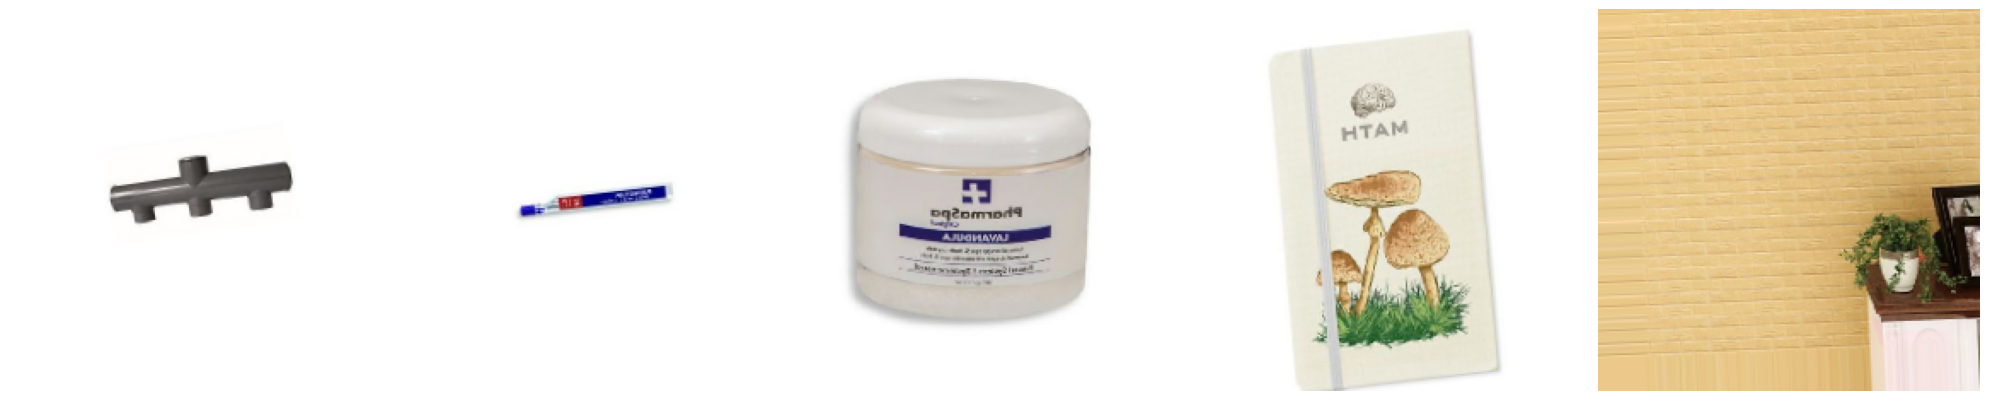

In [12]:
import matplotlib.pyplot as plt


# Création d'une fonction pour tracer des images dans une grille
def plotImages(images_arr, titles=None):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    if titles is not None:
        for title, ax in zip(titles, axes):
            ax.set_title(title)
    plt.tight_layout()
    plt.show()


# Générer des lots d'images augmentées
example_training_images, example_training_labels = next(train_generator)

# Convertir les images en unsigned integers pour l'affichage
example_training_images = example_training_images.astype("uint8")

# Afficher des exemples d'images augmentées
plotImages(example_training_images[:5])

In [13]:
# Chargement de EfficientNetB0 comme base du modèle
from tensorflow.keras.applications import EfficientNetB0
from keras.metrics import F1Score

base_model = EfficientNetB0(
    include_top=False, weights="imagenet", input_tensor=Input(shape=(224, 224, 3))
)

# Ajout des couches personnalisées
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)  # taux de dropout à 0.5 pour réduire le surapprentissage
predictions = Dense(len(y_train.unique()), activation="softmax")(
    x
)  # ajustement du nombre de classes selon y_train

model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle pré-entraîné pour ne pas les ré-entraîner
for layer in base_model.layers:
    layer.trainable = False

# Compilation du modèle
f1_score = F1Score(average="weighted")
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1_score])

# Afficher le résumé du modèle
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 5,388,990 (20.56 MB)

 Trainable params: 1,339,419 (5.11 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
# Entraînement du modèle
history = model.fit(
    train_generator, epochs=10, validation_data=test_generator, batch_size=128
)  # augmentation du nombre d'époques à 10

Epoch 1/10


/opt/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


531/531 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - accuracy: 0.4591 - f1_score: 0.4381 - loss: 1.8644 - val_accuracy: 0.5731 - val_f1_score: 0.5609 - val_loss: 1.4113
Epoch 2/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - accuracy: 0.5738 - f1_score: 0.5626 - loss: 1.4185 - val_accuracy: 0.5926 - val_f1_score: 0.5799 - val_loss: 1.3418
Epoch 3/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 539s 1s/step - accuracy: 0.6032 - f1_score: 0.5944 - loss: 1.3064 - val_accuracy: 0.6049 - val_f1_score: 0.5939 - val_loss: 1.3077
Epoch 4/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 547s 1s/step - accuracy: 0.6265 - f1_score: 0.6192 - loss: 1.2209 - val_accuracy: 0.6087 - val_f1_score: 0.6004 - val_loss: 1.2924
Epoch 5/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - accuracy: 0.6423 - f1_score: 0.6359 - loss: 1.1696 - val_accuracy: 0.6169 - val_f1_score: 0.6074 - val_loss: 1.2840
Epoch 6/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 556s 1s/step - accuracy: 0.6538 - f1_score: 0.6483 - loss: 1.1123 - val_accuracy: 0.6247 - val_f1_score: 0.6166 - va

In [8]:
import numpy as np
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)


# Calcul du nombre de steps nécessaire pour parcourir les données sans répétition
train_steps = int(np.ceil(len(X_train) / 32))
test_steps = int(np.ceil(len(X_test) / 32))

# Évaluation du modèle sur l'ensemble d'entraînement
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_steps)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

2123/2123 ━━━━━━━━━━━━━━━━━━━━ 7468s 4s/step - accuracy: 0.7744 - loss: 0.7146
Training Loss: 0.7126609086990356
Training Accuracy: 0.7746128439903259


In [9]:
# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

531/531 ━━━━━━━━━━━━━━━━━━━━ 746s 1s/step - accuracy: 0.6200 - loss: 1.4037
Test Loss: 1.4269795417785645
Test Accuracy: 0.6173457503318787
